## CycleGAN 훈련

### 라이브러리 임포트

In [1]:
import os
import glob
import itertools
import datetime
import PIL
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.utils as vutils
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from PIL import Image

from CycleGAN import GeneratorUNet, Discriminator


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
image_size = 128
batch_size = 1
epochs = 200
lr = 2e-4

data_folder = '../data/apple2orange'
train_A_folder = os.path.join(data_folder, 'trainA')
train_B_folder = os.path.join(data_folder, 'trainB')
test_A_folder = os.path.join(data_folder, 'testA')
test_B_folder = os.path.join(data_folder, 'testB')
image_save_folder = './images/cycleGAN_apple2orange'
model_save_path = './cycle_gan_apple2orange.pth'

os.makedirs(image_save_folder, exist_ok=True)

### 데이터 적재

In [4]:
class MyDataset(Dataset):
    def __init__(self, dataset_A_root, dataset_B_root, transform):
        self.transform = transform
        self.files_A = sorted(glob.glob(dataset_A_root + '/*.*'))
        self.files_B = sorted(glob.glob(dataset_B_root + '/*.*'))
        
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index]))
        item_B = self.transform(Image.open(self.files_B[index]))
        
        return [item_A, item_B]
        
    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

In [5]:
# Use apple2orange dataset
# https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MyDataset(train_A_folder, train_B_folder, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_dataset = MyDataset(test_A_folder, test_B_folder, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)

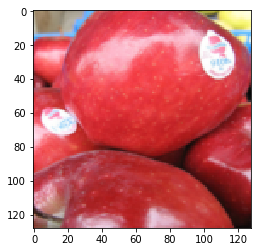

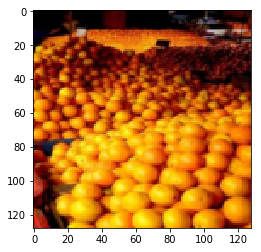

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
image_A, image_B = next(iter(train_loader))
imshow(torchvision.utils.make_grid(image_A))
imshow(torchvision.utils.make_grid(image_B))

### 모델 생성

In [7]:
G_AB = GeneratorUNet().to(device)
G_BA = GeneratorUNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)
G_AB.train()
G_BA.train()
D_A.train()
D_B.train()

Discriminator(
  (b1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [8]:
print(G_AB)

GeneratorUNet(
  (downsample1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (upsample1): Sequential(
    (0): Upsample(scale_factor=2.0

In [9]:
print(D_A)

Discriminator(
  (b1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### 모델 훈련

In [10]:
real_label = 1.
fake_label = 0.

validation_weight = 1
reconstr_weight = 10
id_weight = 2

real_tensor = torch.ones(batch_size, 1, 16, 16).to(device)
fake_tensor = torch.zeros(batch_size, 1, 16, 16).to(device)

D_A_optimizer = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
D_B_optimizer = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))
G_optimizer = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(0.5, 0.999))

In [11]:
def image_loader(image_path, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

[Epoch 0/200] [D loss: 0.199841, acc: 57.15%] [G loss: 7.246143, adv: 0.979628, recon: 0.523930, id: 0.513610] time: 0:00:55.976424
[Epoch 1/200] [D loss: 0.168311, acc: 60.09%] [G loss: 6.298084, adv: 1.149072, recon: 0.431749, id: 0.415760] time: 0:00:56.677616
[Epoch 2/200] [D loss: 0.161803, acc: 60.21%] [G loss: 5.984223, adv: 1.176266, recon: 0.402796, id: 0.390001] time: 0:00:56.634728
[Epoch 3/200] [D loss: 0.157781, acc: 60.16%] [G loss: 5.780603, adv: 1.194498, recon: 0.384293, id: 0.371589] time: 0:00:56.220464
[Epoch 4/200] [D loss: 0.159706, acc: 59.67%] [G loss: 5.640505, adv: 1.188954, recon: 0.372777, id: 0.361889] time: 0:00:56.149044
[Epoch 5/200] [D loss: 0.160410, acc: 58.94%] [G loss: 5.509866, adv: 1.180139, recon: 0.362343, id: 0.353149] time: 0:00:56.382313
[Epoch 6/200] [D loss: 0.157163, acc: 59.53%] [G loss: 5.428671, adv: 1.206863, recon: 0.353119, id: 0.345310] time: 0:00:56.550440
[Epoch 7/200] [D loss: 0.158355, acc: 59.05%] [G loss: 5.313583, adv: 1.2034

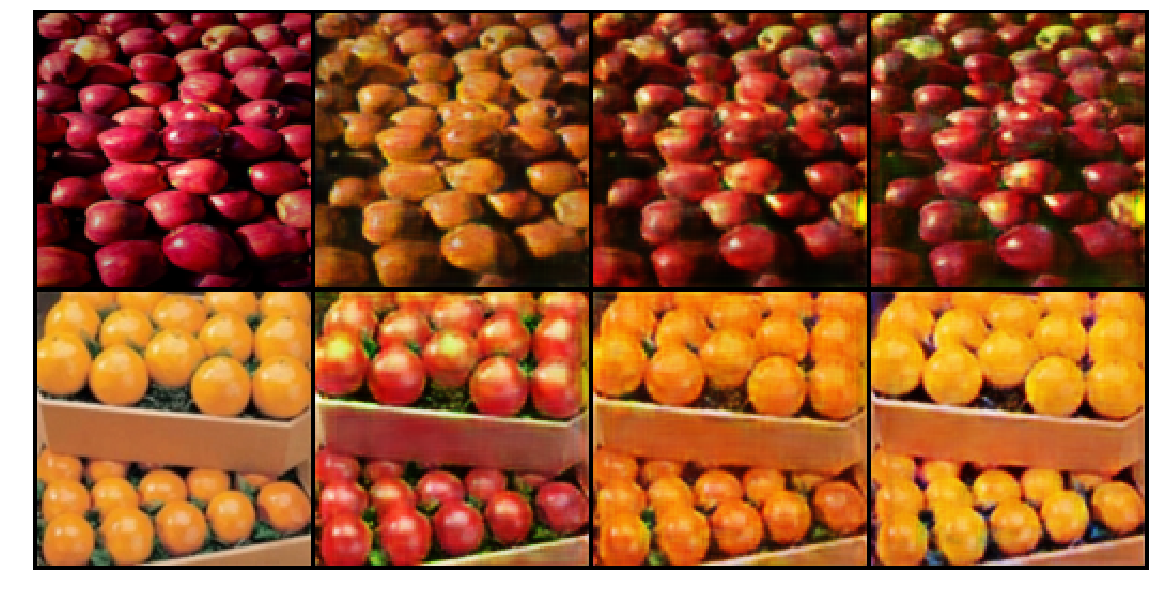

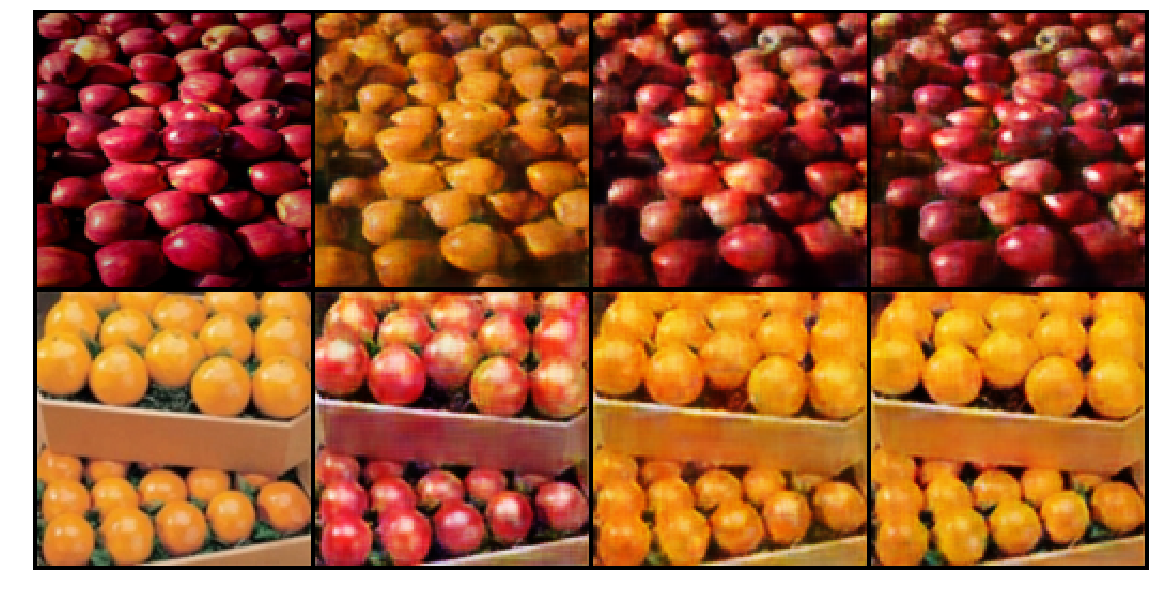

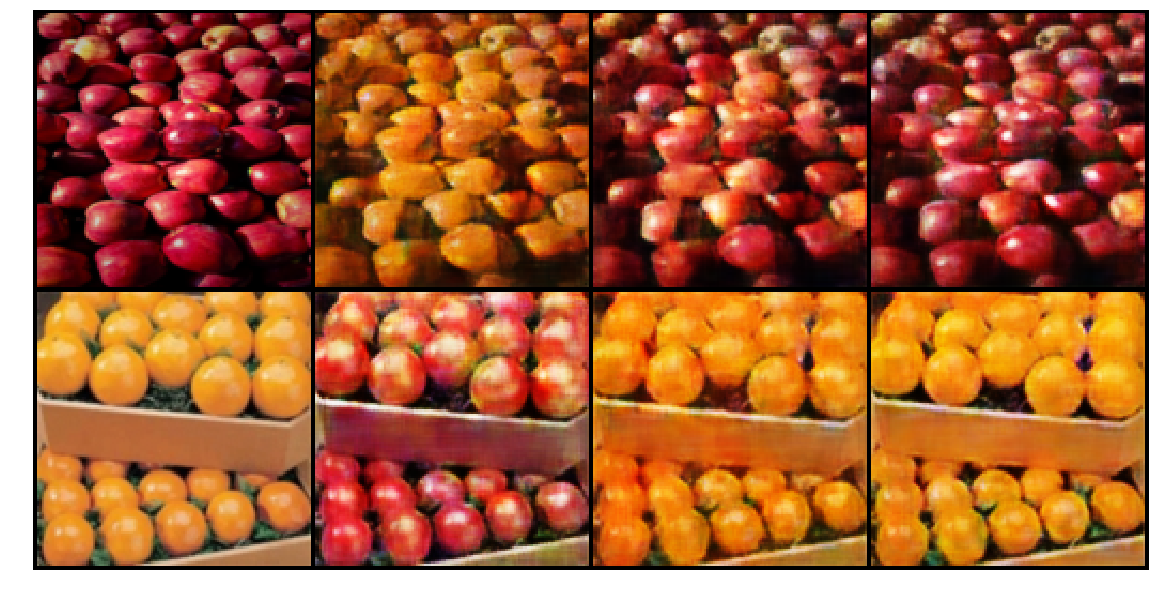

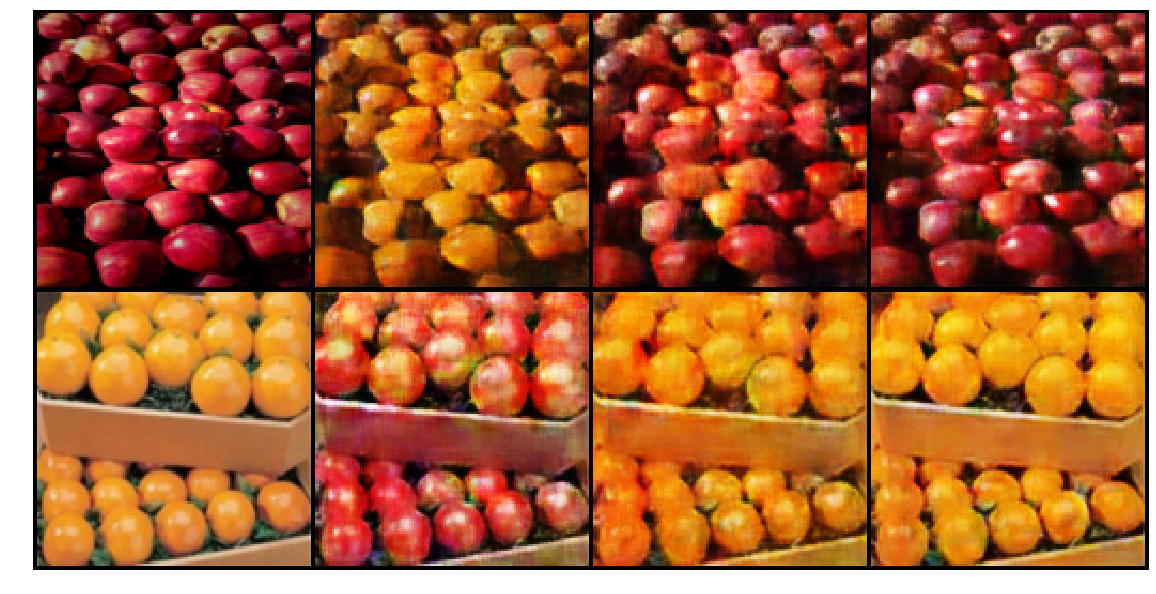

In [12]:
D_losses = []
G_losses = []
validation_losses = []
reconstr_losses = []
id_losses = []
D_accs = []

test_A_filename = 'n07740461_14740.jpg'
test_B_filename = 'n07749192_4241.jpg'

test_A_image = image_loader(os.path.join(data_folder, 'testA', test_A_filename), transform)
test_B_image = image_loader(os.path.join(data_folder, 'testB', test_B_filename), transform)

for epoch in range(epochs):
    epoch_validation_loss = 0.0
    epoch_reconstr_loss = 0.0
    epoch_id_loss = 0.0
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    epoch_D_acc = 0.0
    start_time = datetime.datetime.now()
        
    for inputs_A, inputs_B in train_loader:
        inputs_A = inputs_A.to(device)
        inputs_B = inputs_B.to(device)
        
        fake_B = G_AB(inputs_A)
        fake_A = G_BA(inputs_B)
        
        # Discriminator
        D_A_optimizer.zero_grad()
        
        D_A_real_output = D_A(inputs_A)
        D_A_loss_real = nn.MSELoss()(D_A_real_output, real_tensor)
        D_A_acc_real = D_A_real_output.mean()
        D_A_fake_output = D_A(fake_A)
        D_A_loss_fake = nn.MSELoss()(D_A_fake_output, fake_tensor)
        D_A_acc_fake = 1. - D_A_real_output.mean()
        D_A_loss = 0.5 * (D_A_loss_real + D_A_loss_fake)
        D_A_acc = 0.5 * (D_A_acc_real + D_A_acc_fake)
        
        D_A_loss.backward()
        D_A_optimizer.step()
        
        D_B_optimizer.zero_grad()
        
        D_B_real_output = D_B(inputs_B)
        D_B_loss_real = nn.MSELoss()(D_B_real_output, real_tensor)
        D_B_acc_real = D_B_real_output.mean()
        D_B_fake_output = D_B(fake_B)
        D_B_loss_fake = nn.MSELoss()(D_B_fake_output, fake_tensor)
        D_B_acc_fake = 1. - D_B_fake_output.mean()
        D_B_loss = 0.5 * (D_B_loss_real + D_B_loss_fake)
        D_B_acc = 0.5 * (D_B_acc_real + D_B_acc_fake)

        D_B_loss.backward()
        D_B_optimizer.step()
        
        D_loss = 0.5 * (D_A_loss + D_B_loss)
        D_acc = 0.5 * (D_A_acc + D_B_acc) * 100
        
        # Generator
        for p in D_A.parameters():
            p.requires_grad = False
        for p in D_B.parameters():
            p.requires_grad = False
        
        G_optimizer.zero_grad()
        fake_B = G_AB(inputs_A)
        fake_A = G_BA(inputs_B)
        reconstr_A = G_BA(fake_B)
        reconstr_B = G_AB(fake_A)
        id_A = G_BA(inputs_A)
        id_B = G_AB(inputs_B)
        valid_A = D_A(fake_A)
        valid_B = D_B(fake_B)
        
        validation_loss = nn.MSELoss()(real_tensor, valid_A) +\
                          nn.MSELoss()(real_tensor, valid_B)
        reconstr_loss = nn.L1Loss()(inputs_A, reconstr_A) +\
                        nn.L1Loss()(inputs_B, reconstr_B)
        id_loss = nn.L1Loss()(inputs_A, id_A) +\
                  nn.L1Loss()(inputs_B, id_B)
        G_loss = validation_weight * validation_loss + reconstr_weight * reconstr_loss + id_weight * id_loss
                 
        G_loss.backward()
        G_optimizer.step()
        
        for p in D_A.parameters():
            p.requires_grad = True
        for p in D_B.parameters():
            p.requires_grad = True
        
        epoch_D_loss += D_loss.item() * inputs_A.size(0)
        epoch_G_loss += G_loss.item() * inputs_A.size(0)
        epoch_validation_loss += validation_loss.item() * inputs_A.size(0)
        epoch_reconstr_loss += reconstr_loss.item() * inputs_A.size(0)
        epoch_id_loss += id_loss.item() * inputs_A.size(0)
        epoch_D_acc += D_acc.item() * inputs_A.size(0)

    epoch_D_loss /= train_dataset_size
    epoch_G_loss /= train_dataset_size
    epoch_validation_loss /= train_dataset_size
    epoch_reconstr_loss /= train_dataset_size
    epoch_id_loss /= train_dataset_size
    epoch_D_acc /= train_dataset_size
    
    D_losses.append(epoch_D_loss)
    G_losses.append(epoch_G_loss)
    validation_losses.append(epoch_validation_loss)
    reconstr_losses.append(epoch_reconstr_loss)
    id_losses.append(epoch_id_loss)
    D_accs.append(epoch_D_acc)
        
    elapsed_time = datetime.datetime.now() - start_time
    print("[Epoch %d/%d] [D loss: %f, acc: %.2f%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s"\
        % (epoch, epochs,
           epoch_D_loss, epoch_D_acc,
           epoch_G_loss,
           epoch_validation_loss,
           epoch_reconstr_loss,
           epoch_id_loss,
           elapsed_time))
    
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            fake_B = G_AB(test_A_image)
            fake_A = G_BA(test_B_image)
            reconstr_A = G_BA(fake_B)
            reconstr_B = G_AB(fake_A)
            id_A = G_BA(test_A_image)
            id_B = G_AB(test_B_image)
        
        result_imgs = torch.cat([test_A_image, fake_B, reconstr_A, id_A,
                                 test_B_image, fake_A, reconstr_B, id_B], dim=0).detach().cpu()
        plt.figure(figsize=(20, 12))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(result_imgs,
                                                 nrow=4,
                                                 padding=2,
                                                 normalize=True), (1, 2, 0)))
        plt.savefig(os.path.join(image_save_folder, f'result_img_e_{epoch + 1}.png'))
        
        torch.save({'d_A': D_A.state_dict(),
                    'd_B': D_B.state_dict(),
                    'g_AB': G_AB.state_dict(),
                    'g_BA': G_BA.state_dict()},
                   model_save_path)

### 손실

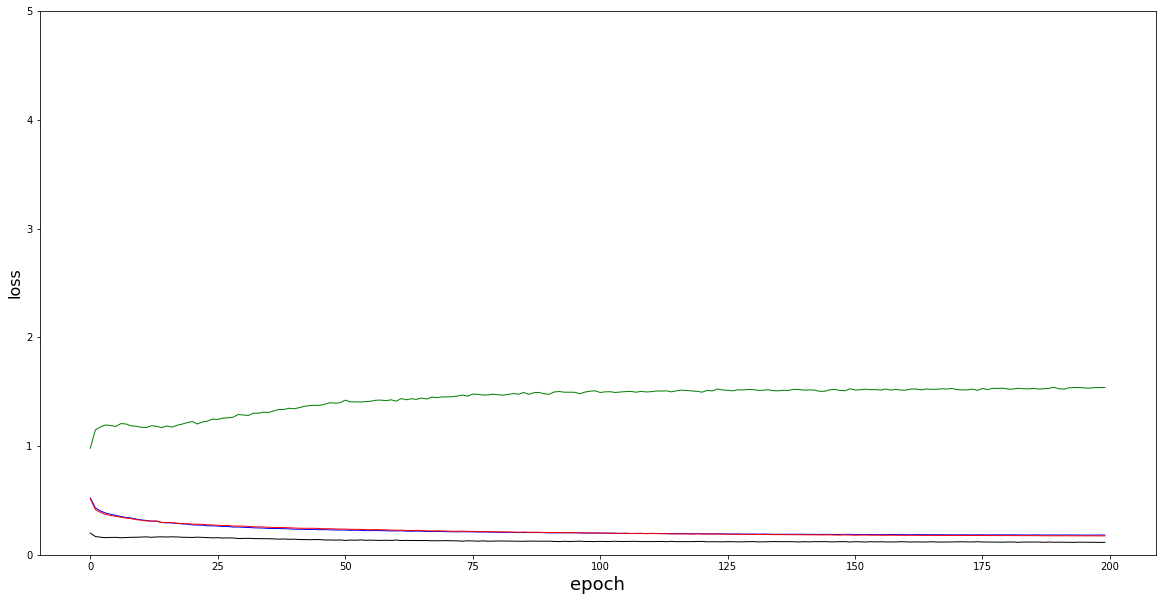

In [13]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in D_losses], color='black', linewidth=1)
plt.plot([x for x in validation_losses], color='green', linewidth=1)
plt.plot([x for x in reconstr_losses], color='blue', linewidth=1)
plt.plot([x for x in id_losses], color='red', linewidth=1)

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.savefig(os.path.join(image_save_folder, 'loss_graph.png'))

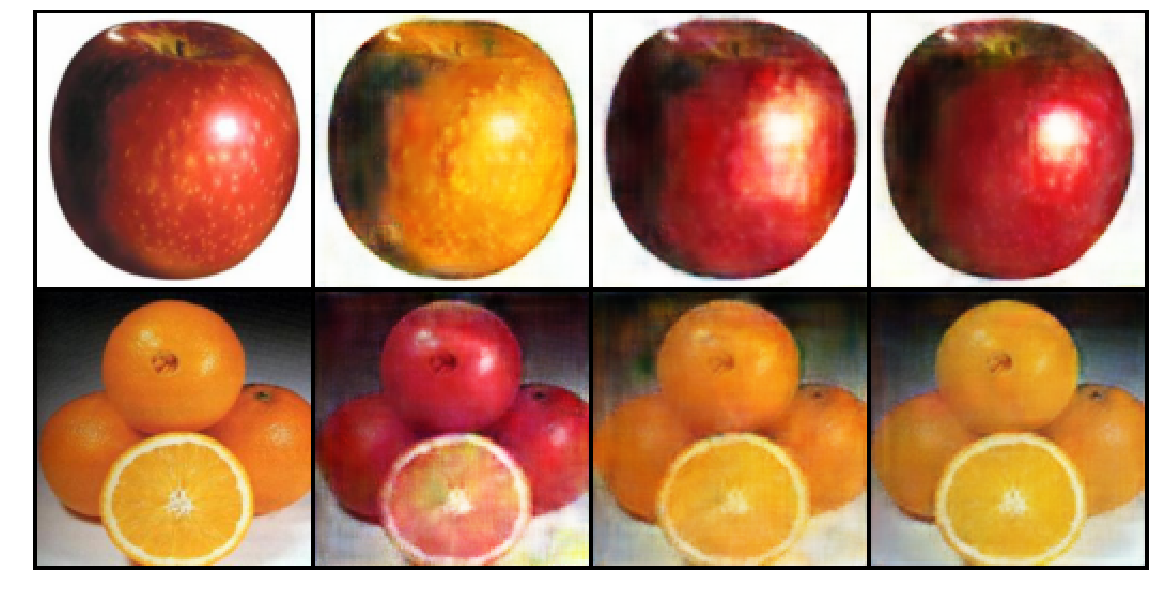

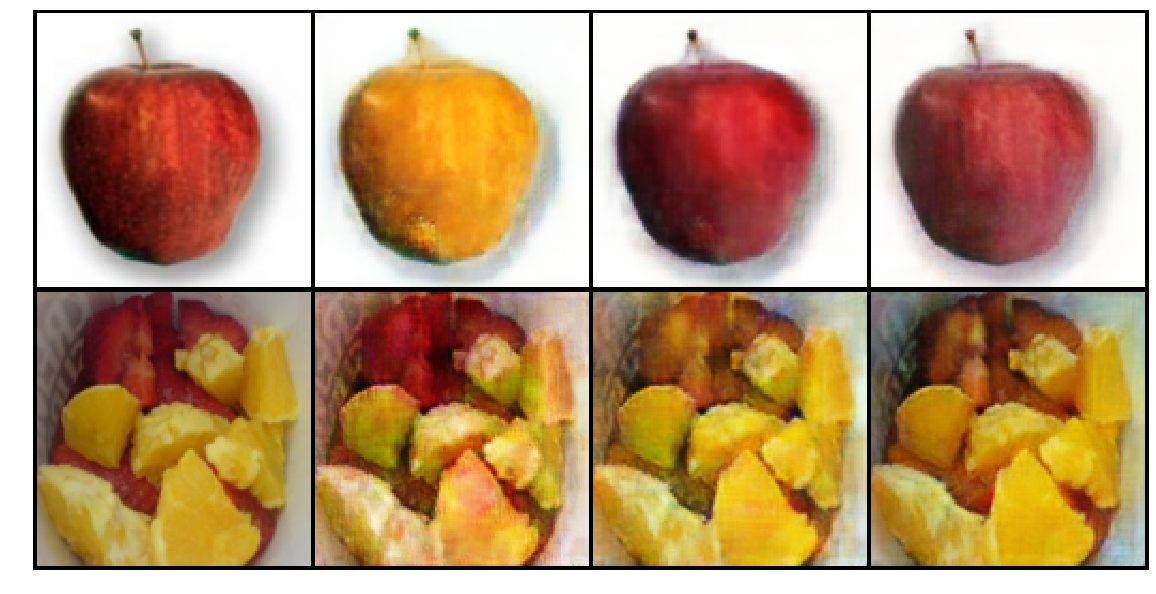

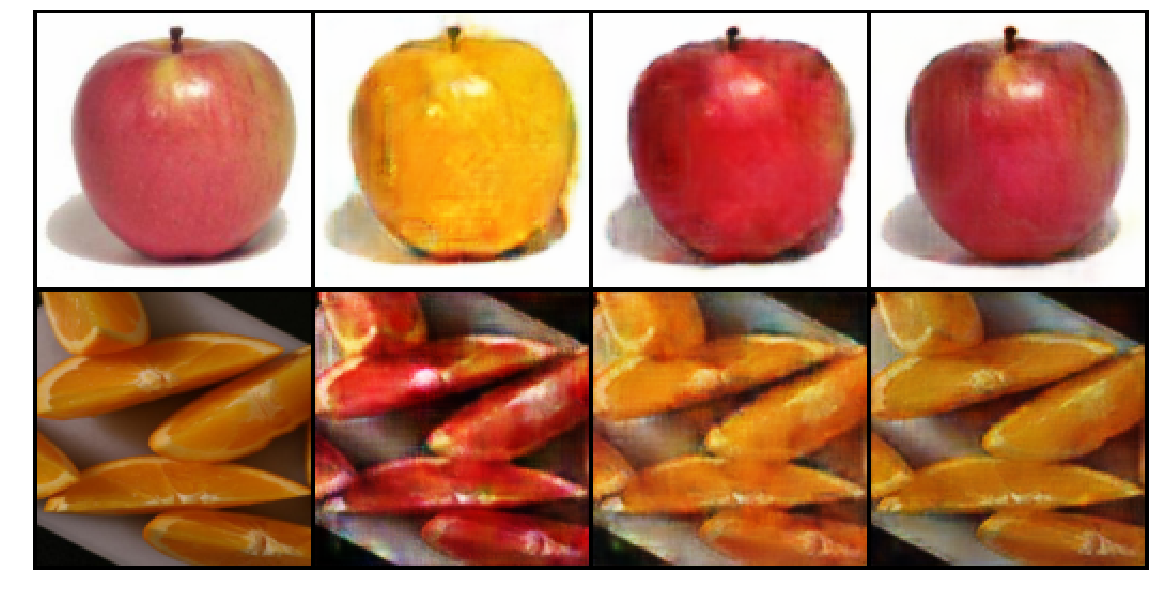

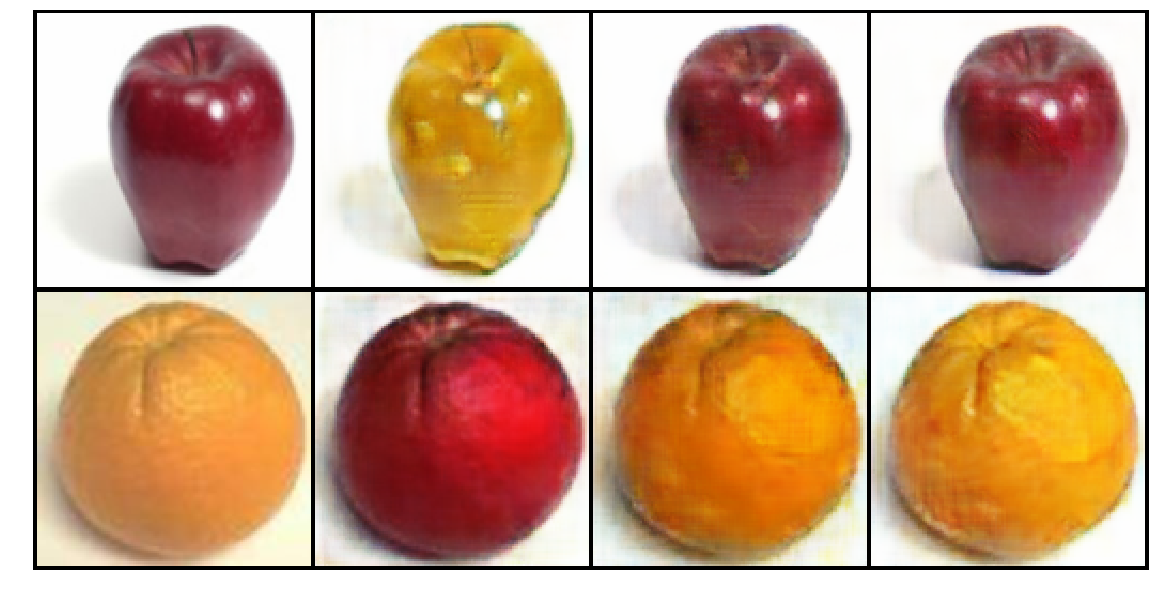

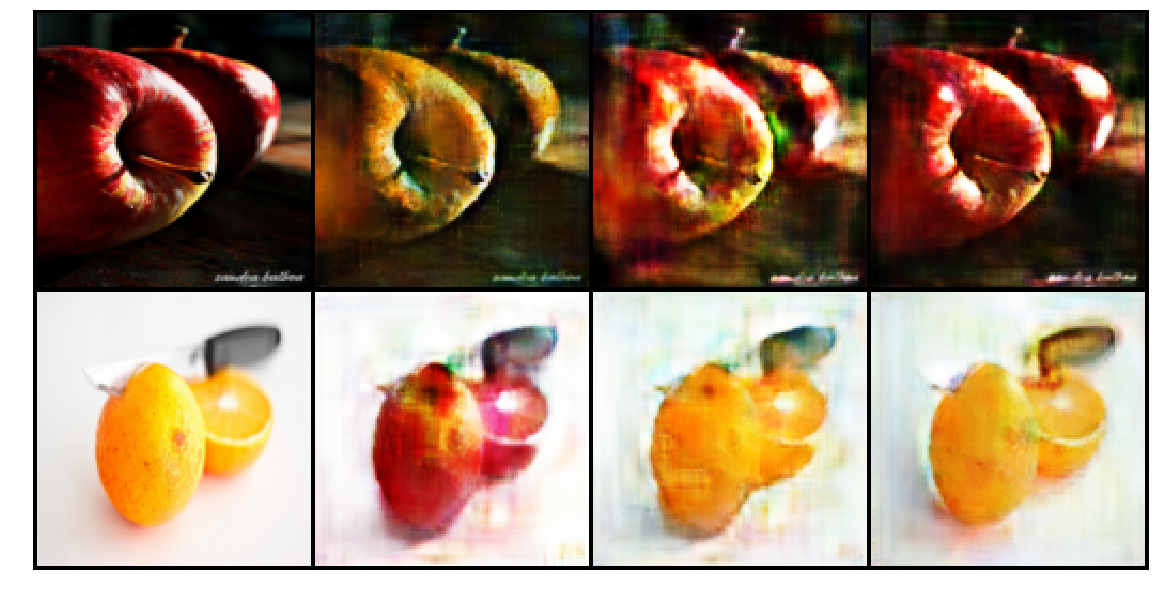

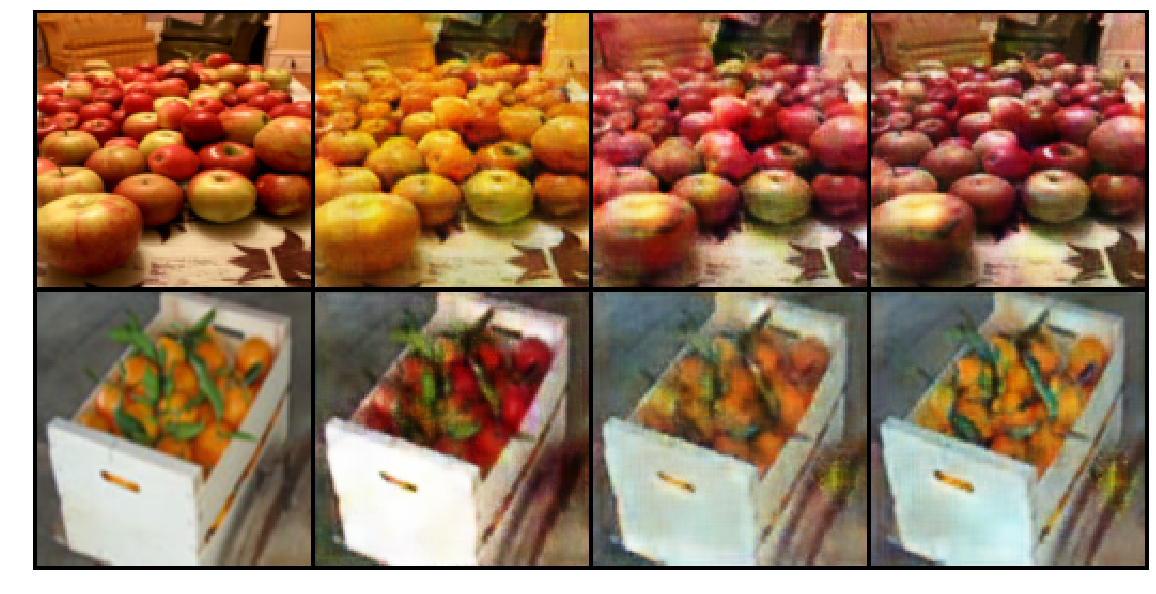

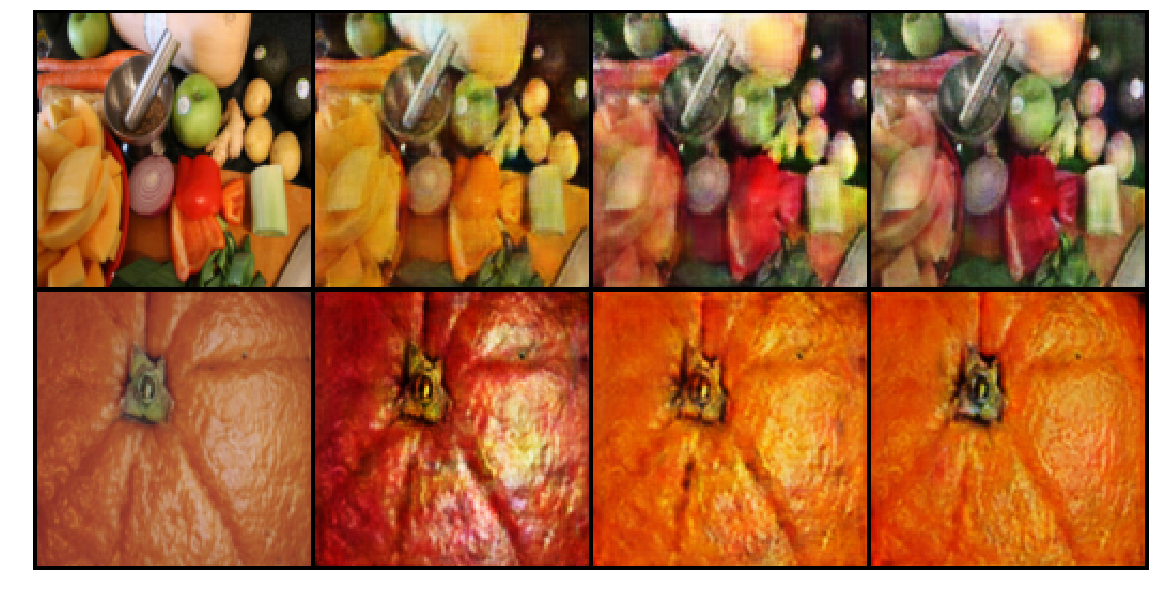

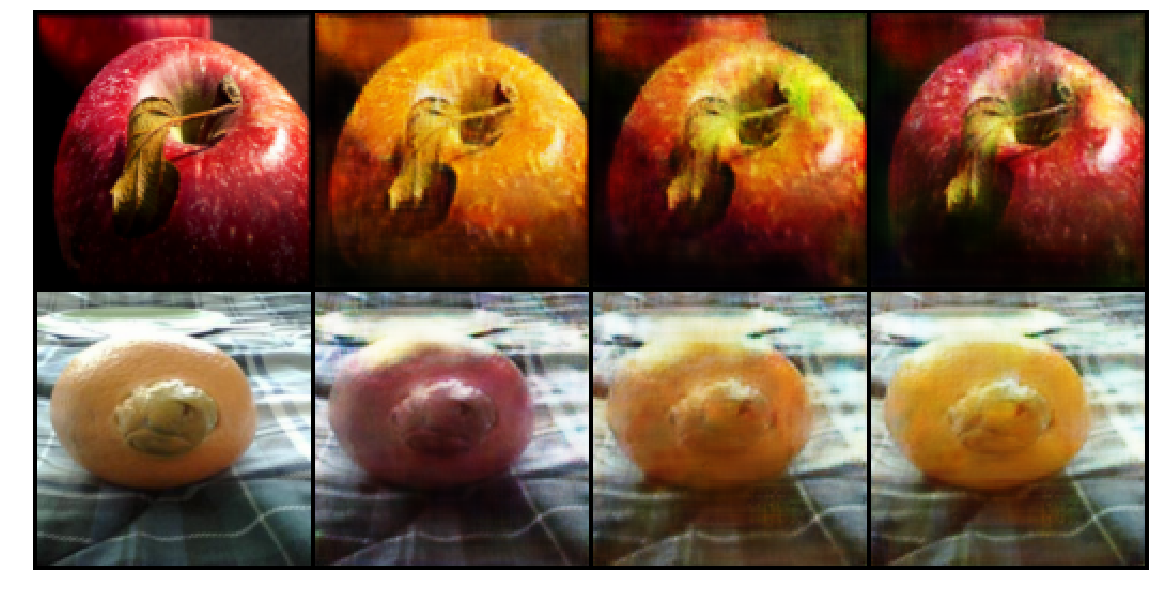

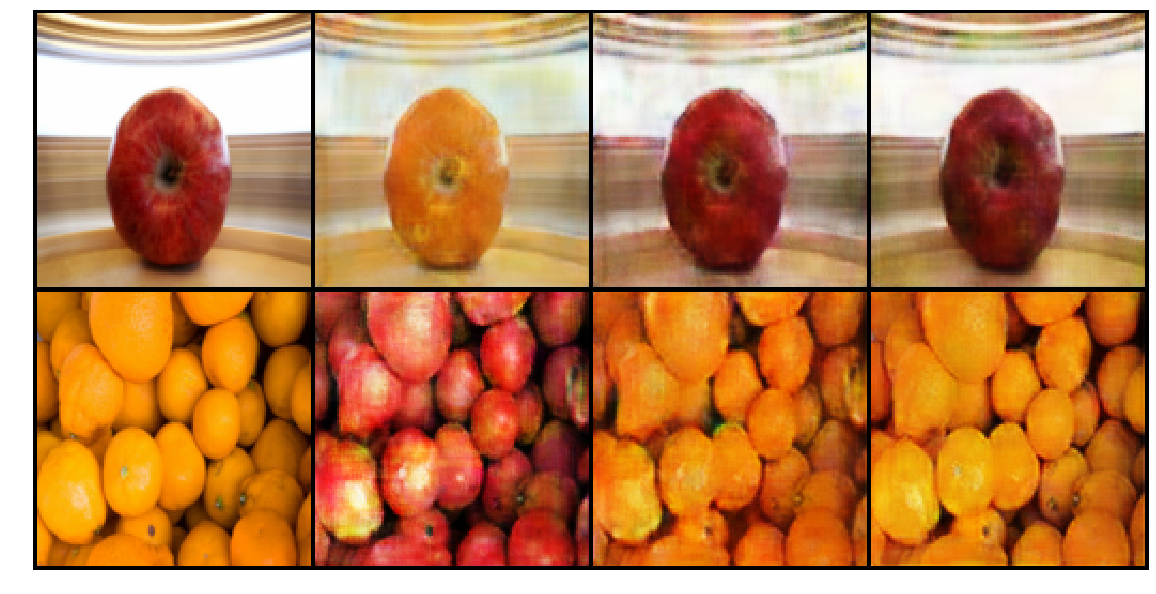

In [14]:
idx = 1
for inputs_A, inputs_B in test_loader:
    inputs_A = inputs_A.to(device)
    inputs_B = inputs_B.to(device)

    fake_B = G_AB(inputs_A)
    fake_A = G_BA(inputs_B)
    reconstr_A = G_BA(fake_B)
    reconstr_B = G_AB(fake_A)
    id_A = G_BA(inputs_A)
    id_B = G_AB(inputs_B)
    valid_A = D_A(fake_A)
    valid_B = D_B(fake_B)

    result_imgs = torch.cat([inputs_A, fake_B, reconstr_A, id_A,
                            inputs_B, fake_A, reconstr_B, id_B], dim=0).detach().cpu()
    plt.figure(figsize=(20, 12))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(result_imgs,
                                                nrow=4,
                                                padding=2,
                                                normalize=True), (1, 2, 0)))
    plt.savefig(os.path.join(image_save_folder, f'test_input_result_img_{idx}.png'))
    idx += 1
    
    if idx % 10 == 0:
        break